<a href="https://colab.research.google.com/github/Ankita-Dey/Thesis/blob/main/XGB_FM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install shap

     |████████████████████████████████| 564 kB 9.2 MB/s 


In [ ]:
import pandas as pd
import math
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import statsmodels.api as sm
from scipy import stats
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from numpy import absolute
import matplotlib.pylab as pl
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import LinearRegression
import xgboost as xgb

from hyperopt import hp, fmin, tpe, STATUS_OK, STATUS_FAIL, Trials, space_eval

import shap
# shap.initjs()


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
df11 = pd.read_csv("drive/MyDrive/Data/C08.csv")

df11 = df11[(df11.Age.isin(["All ages"]))] #['20-24', '24-29','30-34', '34-39','40-44', '44-49','50-54', '54-59','60-64', '64-69']
df11 = df11.groupby(['State', 'District', 'Urban/Rural', 'Caste', 'Sex'], as_index=False).sum()

df11["Graduate & above"] = df11["Graduate & above"] + df11['Non-technical degree'] + df11['Technical degree']
df11["Secondary below Graduate"] = df11["Secondary"] + df11["Higher secondary"]
df11["Secondary & above"] = df11["Secondary"] + df11["Higher secondary"] + df11["Graduate & above"]
df11["Literate below Secondary"] = df11['Literate']-df11['Secondary & above']

for col in df11.columns[6:]:
    df11[col] = df11[col]*100/df11["Total"]

In [ ]:
hh = pd.read_csv("drive/MyDrive/Data/B03.csv")

hh = hh[(hh['Educational level'].isin(['Total']))]
hh = hh.groupby(['State', 'District', 'Urban/Rural', 'Caste', 'Sex'], as_index=False).sum()

hh["Available for work"] = (hh["Marginal worker available for work"]+hh["Non worker available for work"])/hh['Total']
hh["Marginal worker available for work"] = hh['Marginal worker available for work']/hh['Total Marginal worker']
hh["Non worker available for work"] = hh['Non worker available for work']/hh['Total Non worker']
hh["Main worker"] = hh['Main worker']/hh['Total']
hh["Total Marginal worker"] = hh['Total Marginal worker']/hh['Total']
hh["Total Non worker"] = hh['Total Non worker']/hh['Total']

df1 = pd.merge(df11, hh, on=['State', 'District', 'Urban/Rural', 'Caste', 'Sex'], how='inner')

In [ ]:
df2 = pd.read_csv("drive/MyDrive/Data/HH1.csv")[['State', 'District', 'Urban/Rural', 'Caste', 'Total households', 'Total good households']]

hh = pd.read_csv("drive/MyDrive/Data/HH7.csv")[['State', 'District', 'Urban/Rural', 'Caste', 'Electricity']]
df2 = pd.merge(df2, hh, on=['State', 'District', 'Urban/Rural', 'Caste'], how='inner')

hh = pd.read_csv("drive/MyDrive/Data/HH8.csv")[['State', 'District', 'Urban/Rural', 'Caste', 'Households with latrine within premises']]
df2 = pd.merge(df2, hh, on=['State', 'District', 'Urban/Rural', 'Caste'], how='inner')

hh = pd.read_csv("drive/MyDrive/Data/HH9.csv")[['State', 'District', 'Urban/Rural', 'Caste', 'With bathroom']]
df2 = pd.merge(df2, hh, on=['State', 'District', 'Urban/Rural', 'Caste'], how='inner')

hh = pd.read_csv("drive/MyDrive/Data//HH12.csv")[['State', 'District', 'Urban/Rural', 'Caste', 'Households with Radio',
       'Households with TV', 'Households with Computer with internet', 'Households with Computer without internet',
       'Households with Landline only', 'Households with mobile only', 'Households with Landline and mobile', 
       'Households with bicycle', 'Households with motorcycle', 'Households with car','Households with TV, Computer, phone and motor vehicle', 'Households without any assets', 'Households availing banking services']]

hh['Phone'] = hh['Households with Landline only']+hh['Households with mobile only']+hh['Households with Landline and mobile']
hh['Computer'] = hh['Households with Computer with internet'] + hh['Households with Computer without internet']
hh['Vehicle'] = hh['Households with bicycle']+hh['Households with motorcycle']+hh['Households with car']

df2 = pd.merge(df2, hh, on=['State', 'District', 'Urban/Rural', 'Caste'], how='inner')

# # Drinking water
# hh = pd.read_csv("drive/MyDrive/Data/HH6.csv")
# hh_within = hh[(hh['Location of source of drinking water']=='Within the premises')]
# hh_near = hh[(hh['Location of source of drinking water']=='Near the premises')]
# hh_away = hh[(hh['Location of source of drinking water']=='Away')]

# hh = pd.merge(hh_within, hh_near, on=['State', 'District', 'Urban/Rural', 'Caste'], how='inner')
# hh = pd.merge(hh, hh_away, on=['State', 'District', 'Urban/Rural', 'Caste'], how='inner')

# hh = hh.rename(columns={'Total households_x':'Drinking water within premise','Total households_y':'Drinking water near premise','Total households':'Drinking water away from premise'})

# hh = hh[['State', 'District', 'Urban/Rural', 'Caste', 'Drinking water within premise', 'Drinking water near premise', 'Drinking water away from premise']]

# df2 = pd.merge(df2, hh, on=['State', 'District', 'Urban/Rural', 'Caste'], how='inner')

for col in df2.columns[5:]:
    df2[col] = df2[col]*100/df2['Total households']

df2.loc[(df2.State == "CHATTISGARH"), "State"] = "CHHATTISGARH"
df2.loc[(df2.District == "East Nimar"), "District"] = "Khandwa (East Nimar)"
df2.loc[(df2.District == "West Nimar"), "District"] = "Khargone (West Nimar)"

In [ ]:
hh = pd.read_csv("drive/MyDrive/Data/F3.csv")

hh = hh[(hh['Educational level'].isin(['Total']))]
hh = hh.groupby(['State', 'District', 'Urban/Rural', 'Present age'], as_index=False).sum()

hh = hh[(hh['Present age'].isin(['All Ages']))]
hh = hh.groupby(['State', 'District', 'Urban/Rural'], as_index=False).sum()

hh["Average Parity"] = hh['Total Persons']/hh['Total ever married women']
hh = hh[['State', 'District', 'Urban/Rural','Average Parity']]

df2 = pd.merge(df2, hh, on=['State', 'District', 'Urban/Rural'], how='inner')

REGRESSION STARTS HERE

In [ ]:
df = pd.merge(df1, df2, on=["State","District","Urban/Rural","Caste"], how='inner')

# df2[(df2.District!='All')].groupby(['State', 'District'], as_index=False).sum().shape

df = df[(df.Caste=="All") & (df.District!="All") & (df.Sex=='Male') & (df['Urban/Rural']!='Total')].dropna()
df3 = df.copy()
# load data
cols = ['Urban/Rural',  'Total Marginal worker', 'Non worker available for work', 'Total good households', 
        'Households with motorcycle', 'Households availing banking services', 'Average Parity', 
        'Households with Computer with internet', 'Households with Computer without internet', 'Households with car',
    'Main worker', 'Marginal worker available for work', 'Electricity', 'Households with latrine within premises',
       'Households with Radio', 'Households with Landline only', 'Households with mobile only', 'Households with Landline and mobile', 
    'Households with bicycle', ]

for col in cols[1:]:
    df = df[(np.abs(stats.zscore(df[col])) < 5)]
    df[col] = df[col]-df[col].mean()
df = df.dropna()

x = df[cols]
x = pd.get_dummies(data=x, drop_first=True)
# y = df[['Graduate & above']]
# y = df[['Secondary below Graduate']]
y = df[['Literate']]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=8)
scaler_x_train = StandardScaler()
scaler_x_train.fit(x_train)
x_train_scaled = scaler_x_train.transform(x_train)

scaler_x_test = StandardScaler()
scaler_x_test.fit(x_test)
x_test_scaled = scaler_x_test.transform(x_test)

scaler_y_train = StandardScaler()
scaler_y_train.fit(y_train)
y_train_scaled = scaler_y_train.transform(y_train)

scaler_y_test = StandardScaler()
scaler_y_test.fit(y_test)
y_test_scaled = scaler_y_test.transform(y_test)


model = LinearRegression()
model.fit(x_train_scaled, y_train_scaled)
y_pred_scaled = model.predict(x_test_scaled)
y_pred = scaler_y_test.inverse_transform(y_pred_scaled)

print(mean_absolute_error(y_test, y_pred), math.sqrt(mean_squared_error(y_test, y_pred)), r2_score(y_test, y_pred))

X2 = sm.add_constant(x)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())


3.958535402640582 5.214581966577589 0.677005904923859
                            OLS Regression Results                            
Dep. Variable:               Literate   R-squared:                       0.692
Model:                            OLS   Adj. R-squared:                  0.687
Method:                 Least Squares   F-statistic:                     145.0
Date:                Tue, 10 May 2022   Prob (F-statistic):          8.02e-297
Time:                        02:39:49   Log-Likelihood:                -3828.2
No. Observations:                1245   AIC:                             7696.
Df Residuals:                    1225   BIC:                             7799.
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                                                coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------

In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only


In [ ]:
x.shape

NameError: ignored

In [ ]:
df = pd.merge(df1, df2, on=["State","District","Urban/Rural","Caste"], how='inner')
# df2[(df2.District!='All')].groupby(['State', 'District'], as_index=False).sum().shape

df = df[(df.Caste=="All") & (df.District!="All") & (df.Sex!='Persons') & (df['Urban/Rural']!='Total')].dropna()
df3 = df.copy()
# load data
cols = ['Sex', 'Urban/Rural', 'Main worker', 'Total Marginal worker', 'Marginal worker available for work',
       'Non worker available for work', 'Total good households', 'Electricity', 
       'Households with Radio', 'Households availing banking services', 
        'Average Parity', 'Households with Landline only', 'Households with mobile only', 'Households with Landline and mobile', 
        'Households with Computer with internet', 'Households with car',]
    # 'Households with latrine within premises', 'Households with bicycle', 'Households with motorcycle', 


for col in cols[2:]:
    df = df[(np.abs(stats.zscore(df[col])) < 5)]
    df[col] = df[col]-df[col].mean()

df = df.dropna()

x = df[cols]
x = pd.get_dummies(data=x, drop_first=True)
# y = df[['Graduate & above']]
y = df[['Secondary below Graduate']]
# y = df[['Literate']]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=8)

scaler_x_train = StandardScaler()
scaler_x_train.fit(x_train)
x_train_scaled = scaler_x_train.transform(x_train)

scaler_x_test = StandardScaler()
scaler_x_test.fit(x_test)
x_test_scaled = scaler_x_test.transform(x_test)

scaler_y_train = StandardScaler()
scaler_y_train.fit(y_train)
y_train_scaled = scaler_y_train.transform(y_train)

scaler_y_test = StandardScaler()
scaler_y_test.fit(y_test)
y_test_scaled = scaler_y_test.transform(y_test)

model = LinearRegression()
model.fit(x_train_scaled, y_train_scaled)
y_pred_scaled = model.predict(x_test_scaled)
y_pred = scaler_y_test.inverse_transform(y_pred_scaled)

print(mean_absolute_error(y_test, y_pred), math.sqrt(mean_squared_error(y_test, y_pred)), r2_score(y_test, y_pred))

X2 = sm.add_constant(x)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

# 2.5243859702859908 3.401460803048762 0.778197728930528
# 0.795 381.9
# 2.531161620075224 3.2400618958988523 0.7849380926929742
# 0.794 639.4

2.6060403809058514 3.453594632229108 0.7670612208851998
                               OLS Regression Results                               
Dep. Variable:     Secondary below Graduate   R-squared:                       0.779
Model:                                  OLS   Adj. R-squared:                  0.778
Method:                       Least Squares   F-statistic:                     546.5
Date:                      Sun, 08 May 2022   Prob (F-statistic):               0.00
Time:                              22:20:48   Log-Likelihood:                -6553.9
No. Observations:                      2491   AIC:                         1.314e+04
Df Residuals:                          2474   BIC:                         1.324e+04
Df Model:                                16                                         
Covariance Type:                  nonrobust                                         
                                             coef    std err          t      P>|t|      [0.025


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only


In [ ]:
df = pd.merge(df1, df2, on=["State","District","Urban/Rural","Caste"], how='inner')
# df2[(df2.District!='All')].groupby(['State', 'District'], as_index=False).sum().shape

df = df[(df.Caste=="All") & (df.District!="All") & (df.Sex!='Persons') & (df['Urban/Rural']!='Total')].dropna()
df3 = df.copy()
# load data
cols = ['Sex', 'Main worker', 'Total Marginal worker', 'Marginal worker available for work',
       'Non worker available for work', 'Total good households', 'Electricity', 'Households with latrine within premises',
       'Households with Radio', 'Households with bicycle', 'Households availing banking services', 
        'Average Parity', 'Households with mobile only', 'Households with Landline and mobile', 
        'Households with Computer without internet', 'Households with car',]
    #   'Urban/Rural',  'Households with motorcycle', 'Households with Computer with internet', 'Households with Landline only',


for col in cols[1:]:
    df = df[(np.abs(stats.zscore(df[col])) < 5)]
    df[col] = df[col]-df[col].mean()

df = df.dropna()

x = df[cols]
x = pd.get_dummies(data=x, drop_first=True)
# y = df[['Graduate & above']]
# y = df[['Secondary below Graduate']]
y = df[['Literate']]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=18)

scaler_x_train = StandardScaler()
scaler_x_train.fit(x_train)
x_train_scaled = scaler_x_train.transform(x_train)

scaler_x_test = StandardScaler()
scaler_x_test.fit(x_test)
x_test_scaled = scaler_x_test.transform(x_test)

scaler_y_train = StandardScaler()
scaler_y_train.fit(y_train)
y_train_scaled = scaler_y_train.transform(y_train)

scaler_y_test = StandardScaler()
scaler_y_test.fit(y_test)
y_test_scaled = scaler_y_test.transform(y_test)

model = LinearRegression()
model.fit(x_train_scaled, y_train_scaled)
y_pred_scaled = model.predict(x_test_scaled)
y_pred = scaler_y_test.inverse_transform(y_pred_scaled)

print(mean_absolute_error(y_test, y_pred), math.sqrt(mean_squared_error(y_test, y_pred)), r2_score(y_test, y_pred))

X2 = sm.add_constant(x)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

# OLD 4.747456280263818 6.20752480498066 0.7738728194388436
# 0.777 342.1
# 4.514732329107534 6.053287156048274 0.7681677205602592
# 0.776  451.9
# NEW 4.643180690068617 6.000342795860839 0.7791154553829419
# 0.765 400.9
# 4.62309615533111 6.0106670006018685 0.7683564949083397
# 0.766  509.1

4.62309615533111 6.0106670006018685 0.7683564949083397
                            OLS Regression Results                            
Dep. Variable:               Literate   R-squared:                       0.766
Model:                            OLS   Adj. R-squared:                  0.765
Method:                 Least Squares   F-statistic:                     509.1
Date:                Sun, 08 May 2022   Prob (F-statistic):               0.00
Time:                        22:50:28   Log-Likelihood:                -8189.7
No. Observations:                2505   AIC:                         1.641e+04
Df Residuals:                    2488   BIC:                         1.651e+04
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------

In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only


XGBOOST STARTS HERE

In [ ]:
df = pd.merge(df1, df2, on=["State","District","Urban/Rural","Caste"], how='inner')
# df2[(df2.District!='All')].groupby(['State', 'District'], as_index=False).sum().shape

df = df[(df.Caste=="All") & (df.District!="All") & (df.Sex=='Male') & (df['Urban/Rural']!='Total')].dropna()
df3 = df.copy()
# load data
cols = ['Sex', 'Urban/Rural', 'Main worker', 'Total Marginal worker', 'Marginal worker available for work',
       'Non worker available for work', 'Total good households', 'Electricity', 'Households with latrine within premises',
       'Households with Radio', 'Households with bicycle', 'Households with motorcycle', 'Households availing banking services', 
        'Average Parity', 'Households with Landline only', 'Households with mobile only', 'Households with Landline and mobile', 
        'Households with Computer with internet', 'Households with Computer without internet', 'Households with car',
        'With bathroom', 'Households with TV',]  # 'Households with TV, Computer, phone and motor vehicle', 
    #  'Households without any assets','Phone', 'Computer', 'Available for work', 'Total Non worker',

for col in cols[2:]:
    df = df[(np.abs(stats.zscore(df[col])) < 5)]
    df[col] = df[col]-df[col].mean()

df = df.dropna()

x = df[cols]
x = pd.get_dummies(data=x, drop_first=True)
# y = df[['Graduate & above']]
# y = df[['Secondary below Graduate']]
y = df[['Literate']]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=8)
print(x.shape, y.shape, x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(1244, 21) (1244, 1) (995, 21) (249, 21) (995, 1) (249, 1)


In [ ]:
# # Unique districts = (637, 26)
# # before removing outliers, df.shape = 2523, 50, unique districts = 637, 26

# df[['State', 'District', 'Sex', 'Urban/Rural', 'Main worker', 'Total Marginal worker', 'Marginal worker available for work',
#        'Total Non worker', 'Non worker available for work', 'Available for work', 'Total good households',
#        'Electricity', 'Households with latrine within premises', 'With bathroom', 'Households with Radio', 'Households with TV',
#        'Households with Computer with internet', 'Households with Computer without internet', 'Households with Landline only', 
#        'Households with mobile only', 'Households with Landline and mobile', 'Households with bicycle', 'Households with motorcycle', 
#        'Households with car', 'Households with TV, Computer, phone and motor vehicle', 'Households without any assets', 
#        'Households availing banking services', 'Average Parity']].groupby(['State', 'District'], as_index=False).sum().shape

In [ ]:
# print(x.shape, y.shape, x_train.shape, x_test.shape, y_train.shape, y_test.shape)

In [ ]:
space={
    'learning_rate':    hp.choice('eta',    [0.05, 0.10, 0.15, 0.20, 0.25, 0.30]),
    'max_depth':        hp.choice('max_depth',        [ 3, 4, 5, 6, 7, 8, 9, 10]),
    'min_child_weight': hp.choice('min_child_weight', [ 1, 2, 3, 5, 6, 7]),
    'colsample_bytree': hp.choice('colsample_bytree', [ 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
    'subsample':        hp.uniform('subsample', 0.8, 1),
    'n_estimators':     hp.choice('n_estimators', [ 100,150,200,250,300]),
    'gamma':            hp.choice('gamma', [ 0.0, 0.1, 0.2 , 0.3, 0.4, 0.5 ])
    # 'reg_alpha' :       hp.quniform('reg_alpha', 40,180,1),
    # 'reg_lambda' :      hp.uniform('reg_lambda', 0,1)
}

In [ ]:
def objective(space):
    clf=xgb.XGBRegressor(**space)
                    # n_estimators =space['n_estimators'], max_depth = int(space['max_depth']), gamma = space['gamma'],
                    # min_child_weight=int(space['min_child_weight']),
                    # colsample_bytree=int(space['colsample_bytree'])) #reg_alpha = int(space['reg_alpha']),
    
    evaluation = [( x_train, y_train), ( x_test, y_test)]
    
    clf.fit(x_train, y_train,
            eval_set=evaluation, eval_metric="rmse", #auc
            early_stopping_rounds=10,verbose=False)
    

    pred = clf.predict(x_test)
    rmse = math.sqrt(mean_squared_error(y_test, pred))
    print ("SCORE:", rmse)
    return {'loss': rmse, 'status': STATUS_OK }

In [ ]:
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)

[02:39:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
SCORE:
3.945935503671791
[02:39:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
SCORE:
4.627071259823672
[02:39:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
SCORE:
4.07278206803195
[02:39:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
SCORE:
4.210841738204357
[02:39:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
SCORE:
4.202234277027349
[02:39:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
SCORE:
4.002165123277409
[02:39:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now dep

In [ ]:
space_eval(space, best_hyperparams)

{'colsample_bytree': 0.8,
 'gamma': 0.4,
 'learning_rate': 0.1,
 'max_depth': 8,
 'min_child_weight': 5,
 'n_estimators': 150,
 'subsample': 0.8887276673396034}

[00:15:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
1.1970188423433488 1.5983376563927356 0.9099127548254047


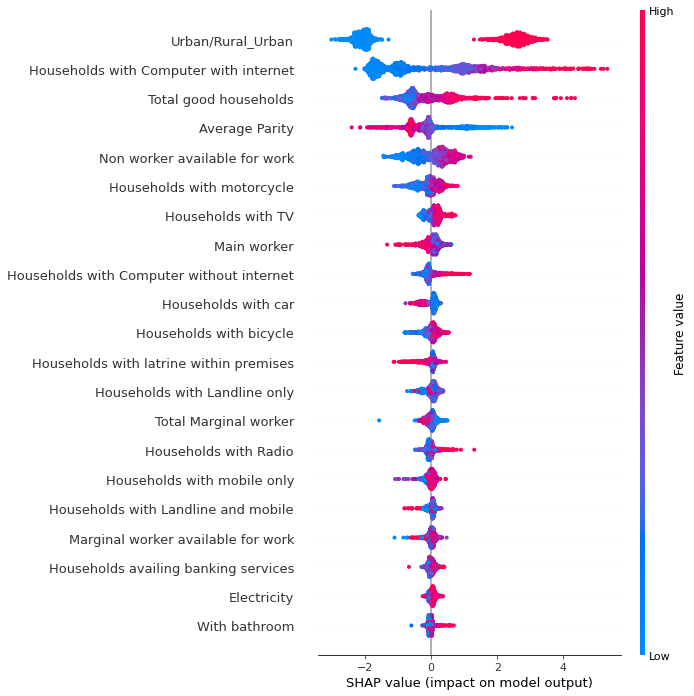

In [ ]:
# Graduate & above MALE
model = XGBRegressor(colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=5, min_child_weight=1, n_estimators=100, subsample=0.837)

model.fit(x_train, y_train)
y_pred = model.predict(x_test)
print(mean_absolute_error(y_test, y_pred), math.sqrt(mean_squared_error(y_test, y_pred)), r2_score(y_test, y_pred))
# best loss: 1.581798646364747
# 1.1970188423433488 1.5983376563927356 0.9099127548254047

explainer = shap.Explainer(model)
shap_values = explainer(x)
shap.summary_plot(shap_values, max_display=40, show=False)
fig = plt.gcf() # gcf means "get current figure"
fig.set_figwidth(10)
plt.rcParams['font.size'] = '14'
fig.tight_layout()
plt.show()

[00:03:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
0.8863603822011638 1.3184210865956771 0.9200984673801366


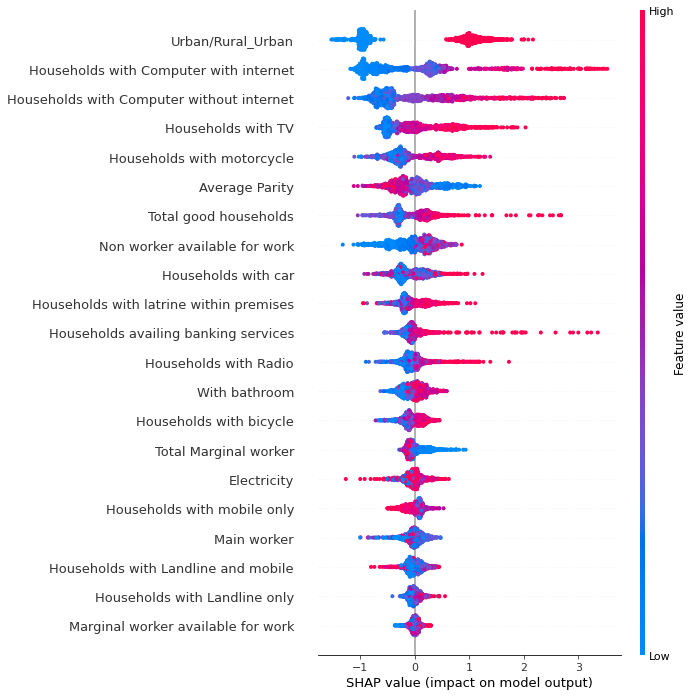

In [ ]:
# Graduate & above FEMALE
model = XGBRegressor(colsample_bytree=0.5, gamma=0.0, learning_rate=0.2, max_depth=5, min_child_weight=6, n_estimators=250, subsample=0.806)

model.fit(x_train, y_train)
y_pred = model.predict(x_test)
print(mean_absolute_error(y_test, y_pred), math.sqrt(mean_squared_error(y_test, y_pred)), r2_score(y_test, y_pred))
# best loss: 1.259917705849914
# 0.8863603822011638 1.3184210865956771 0.9200984673801366

explainer = shap.Explainer(model)
shap_values = explainer(x)

shap.summary_plot(shap_values, max_display=40, show=False)
# shap.plots.heatmap(shap_values)

fig = plt.gcf() # gcf means "get current figure"
# fig.set_figheight(11)
fig.set_figwidth(10)
plt.rcParams['font.size'] = '14'
# fig.suptitle(degree)
fig.tight_layout()
# plt.savefig('SummaryPlots/'+sex+place+'-'+degree+'.PNG', dpi=600, bbox_inches='tight')
plt.show()

[00:18:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
2.0940708174961222 2.7196964464230047 0.8125974946086233


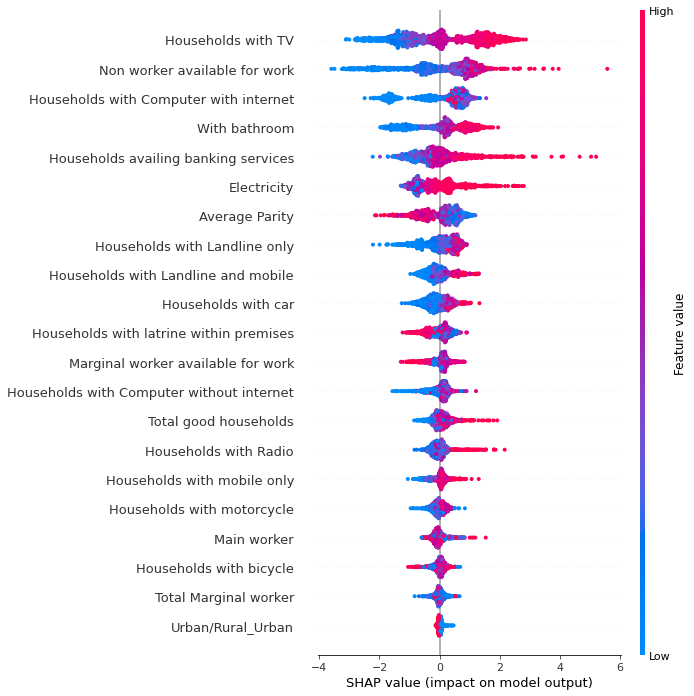

In [ ]:
# Secondary below Graduate MALE
model = XGBRegressor(colsample_bytree=0.3, gamma=0.1, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=150, subsample=0.956)

model.fit(x_train, y_train)
y_pred = model.predict(x_test)
print(mean_absolute_error(y_test, y_pred), math.sqrt(mean_squared_error(y_test, y_pred)), r2_score(y_test, y_pred))
# best loss: 2.729825518662308
# 2.0940708174961222 2.7196964464230047 0.8125974946086233

explainer = shap.Explainer(model)
shap_values = explainer(x)
shap.summary_plot(shap_values, max_display=40, show=False)
fig = plt.gcf() # gcf means "get current figure"
fig.set_figwidth(10)
plt.rcParams['font.size'] = '14'
fig.tight_layout()
plt.show()

[00:21:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
1.675620936001386 2.332060183489488 0.8837522381959279


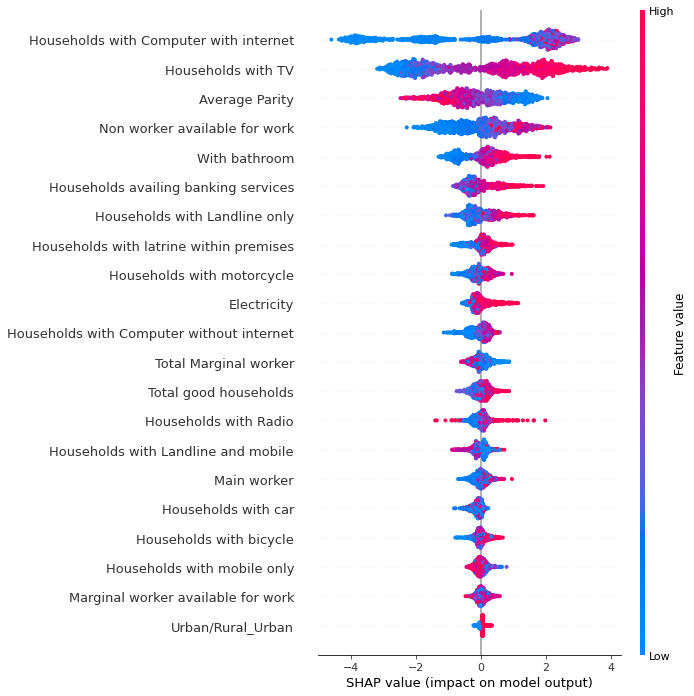

In [ ]:
# Secondary below Graduate FEMALE
model = XGBRegressor(colsample_bytree=0.9, gamma=0.0, learning_rate=0.1, max_depth=9, min_child_weight=7, n_estimators=150, subsample=0.8)

model.fit(x_train, y_train)
y_pred = model.predict(x_test)
print(mean_absolute_error(y_test, y_pred), math.sqrt(mean_squared_error(y_test, y_pred)), r2_score(y_test, y_pred))
# best loss: 2.29319682045397
# 1.675620936001386 2.332060183489488 0.8837522381959279

explainer = shap.Explainer(model)
shap_values = explainer(x)
shap.summary_plot(shap_values, max_display=40, show=False)
fig = plt.gcf() # gcf means "get current figure"
fig.set_figwidth(10)
plt.rcParams['font.size'] = '14'
fig.tight_layout()
plt.show()

[02:44:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
2.7395903425269497 3.745994501951177 0.8278183429334317


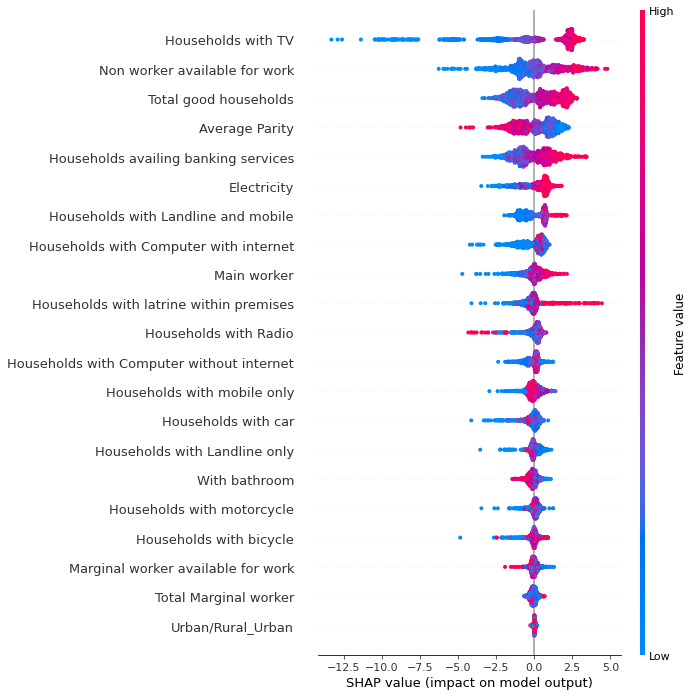

In [ ]:
# Literate MALE
model = XGBRegressor(colsample_bytree=0.7, gamma=0.3, learning_rate=0.05, max_depth=8, min_child_weight=2, n_estimators=300, subsample=0.877)

model.fit(x_train, y_train)
y_pred = model.predict(x_test)
print(mean_absolute_error(y_test, y_pred), math.sqrt(mean_squared_error(y_test, y_pred)), r2_score(y_test, y_pred))
# best loss: 3.7113107720301457
# 2.7395903425269497 3.745994501951177 0.8278183429334317

explainer = shap.Explainer(model)
shap_values = explainer(x)
shap.summary_plot(shap_values, max_display=40, show=False)
fig = plt.gcf() # gcf means "get current figure"
fig.set_figwidth(10)
plt.rcParams['font.size'] = '14'
fig.tight_layout()
plt.show()

[00:10:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
3.4153384498635084 4.508122040499757 0.8847809791403883


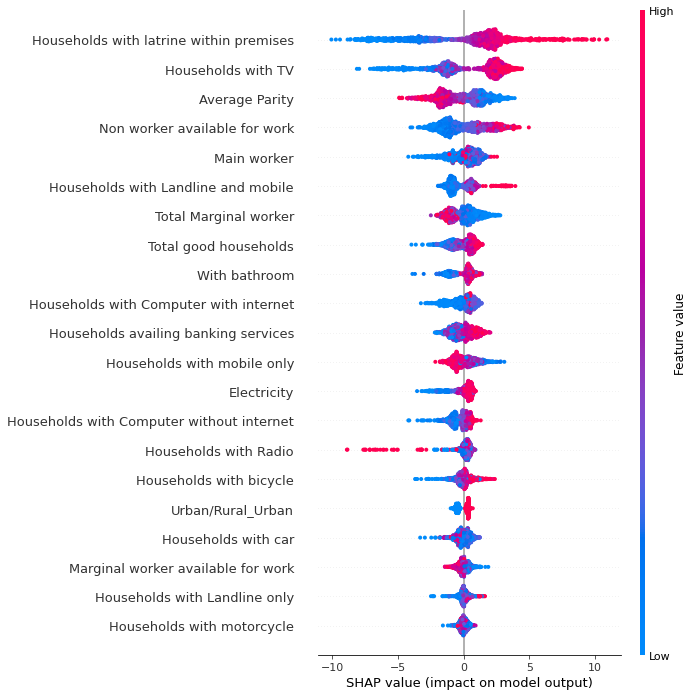

In [ ]:
# Literate FEMALE
model = XGBRegressor(colsample_bytree=0.5, gamma=0.1, learning_rate=0.05, max_depth=7, min_child_weight=2, n_estimators=300, subsample=0.86)

model.fit(x_train, y_train)
y_pred = model.predict(x_test)
print(mean_absolute_error(y_test, y_pred), math.sqrt(mean_squared_error(y_test, y_pred)), r2_score(y_test, y_pred))
# best loss: 4.517996663968229
# 3.4153384498635084 4.508122040499757 0.8847809791403883

explainer = shap.Explainer(model)
shap_values = explainer(x)
shap.summary_plot(shap_values, max_display=40, show=False)
fig = plt.gcf() # gcf means "get current figure"
fig.set_figwidth(10)
plt.rcParams['font.size'] = '14'
fig.tight_layout()
plt.show()